In [172]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [173]:
train = pd.read_csv('~/Documents/AmesHousingML/clean_data_ordinal.csv') 

In [174]:
train

,PID,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_NoAlley,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSewr,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio
0,909176150,856,126000,30,60.0,7890,6,6,1939,1950,0.0,3,3,3,3,1,3,238.0,1,0.0,618.0,856.0,3,856,0,0,1.0,0.0,1,0,2,1,3,4,1,4,1939.0,1,2.0,399.0,3,3,0,0,0,0,166,0,3,2010,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.

## Finding & Dealing with Outliers

In [175]:
train.shape

(2576, 217)

In [176]:
Q1 = train['SalePrice'].quantile(.25)
Q3 = train['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + 5 * IQR

In [177]:
before_outlier_total = train.count()[1]
train.drop(train[train['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train.count()[1]

In [178]:
train.shape

(2571, 217)

In [179]:
before_outlier_total - post_outlier_total

5

In [180]:
train.dtypes.value_counts()

float64    177
int64       40
dtype: int64

In [181]:
#train_numerics = train.select_dtypes(include=[np.number])

In [199]:
masterScores = pd.DataFrame(columns = ['Model', 'r2_score'])


In [182]:
ft_train = train

Below is to create an object that will hold the categories of the one hot encoded variables into an easy way to add / remove the entire feature... Since features can be broken up into 5+ separate columns I needed an easy way to group and adjust the features as a whole.

In [183]:
# Create an empty dictionary to store dummy variables grouped by original categories
dummy_groups = {}

# Iterate through columns and group dummy variables by the original category
for column in ft_train.columns:
    category = column.split('_')[0] # Extract the original category from the column name
    if category not in dummy_groups:
        dummy_groups[category] = [column]
    else:
        dummy_groups[category].append(column)
    

    
# Convert the dictionary values to a list of lists
grouped_dummies = list(dummy_groups.values())

dummy_groups

{'PID': ['PID'],
 'GrLivArea': ['GrLivArea'],
 'SalePrice': ['SalePrice'],
 'MSSubClass': ['MSSubClass'],
 'LotFrontage': ['LotFrontage'],
 'LotArea': ['LotArea'],
 'OverallQual': ['OverallQual'],
 'OverallCond': ['OverallCond'],
 'YearBuilt': ['YearBuilt'],
 'YearRemodAdd': ['YearRemodAdd'],
 'MasVnrArea': ['MasVnrArea'],
 'ExterQual': ['ExterQual'],
 'ExterCond': ['ExterCond'],
 'BsmtQual': ['BsmtQual'],
 'BsmtCond': ['BsmtCond'],
 'BsmtExposure': ['BsmtExposure'],
 'BsmtFinType1': ['BsmtFinType1'],
 'BsmtFinSF1': ['BsmtFinSF1'],
 'BsmtFinType2': ['BsmtFinType2'],
 'BsmtFinSF2': ['BsmtFinSF2'],
 'BsmtUnfSF': ['BsmtUnfSF'],
 'TotalBsmtSF': ['TotalBsmtSF'],
 'HeatingQC': ['HeatingQC'],
 '1stFlrSF': ['1stFlrSF'],
 '2ndFlrSF': ['2ndFlrSF'],
 'LowQualFinSF': ['LowQualFinSF'],
 'BsmtFullBath': ['BsmtFullBath'],
 'BsmtHalfBath': ['BsmtHalfBath'],
 'FullBath': ['FullBath'],
 'HalfBath': ['HalfBath'],
 'BedroomAbvGr': ['BedroomAbvGr'],
 'KitchenAbvGr': ['KitchenAbvGr'],
 'KitchenQual': ['Kitc

In [184]:
dummy_groups.keys()


dict_keys(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'Fence', 'MoSold', 'YrSold', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Function

In [185]:
print(grouped_dummies[85])


['QualityOutdoorLotRatio']


Now I want to grab a list of all the values in the dictionary and use that as a check list of sorts to start finding the optimal model in linear regression

In [186]:
train.head()

,PID,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_NoAlley,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSewr,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio
0,909176150,856,126000,30,60.0,7890,6,6,1939,1950,0.0,3,3,3,3,1,3,238.0,1,0.0,618.0,856.0,3,856,0,0,1.0,0.0,1,0,2,1,3,4,1,4,1939.0,1,2.0,399.0,3,3,0,0,0,0,166,0,3,2010,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.

In [187]:
rScoreStorage = {}

In [188]:
def regression_tester(dict_index):
    #input the index of the columns that 
    currentModelIndexes = current_model_indexes.copy()
    index_list_convert = [dict_index]
    currentModelIndexes.extend(index_list_convert)
    colsTrackerTest = currentModelIndexes
    
    included_colsTest = []
    for col in colsTrackerTest:
        included_colsTest.extend(grouped_dummies[col])

    ft_trainTest = train[included_colsTest]

    #the features will be X (independent variables)
    Xtest = ft_trainTest.drop('SalePrice', axis=1)
    X_arrayTest = Xtest.values
    #the target (dependent variable) will be y
    ytest = ft_trainTest['SalePrice']
    y_arrayTest = ytest.values


    # Perform linear regression using scikit-learn
    modeltest = LinearRegression()
    modeltest.fit(Xtest, ytest)



    # Make predictions using the trained model
    predictionsTest = modeltest.predict(Xtest)

    
    # Rsquared value
    #print("R Squared on the test set:", r2_score(ytest, predictionsTest))
    
    rScoreStorage[dict_index] = r2_score(ytest, predictionsTest)
    
    




In [189]:
#test the indexes of the dataset in LinearRegression 
# for this current given model and store the results:
for x in range(1,86):
    regression_tester(x)


# #adjust this for the current model
# for i in rScoreStorage:
#     print(i, rScoreStorage[i] - r2_score(y, predictions))
    
#adjust this for the current model and the values you want to include; will output the indexes above the range wanted
# desired_r2_threshold = .03
# for i in rScoreStorage:
#     if (rScoreStorage[i] - current_Model_r2 > desired_r2_threshold):
#         print(i)


rMax = 0
for i in rScoreStorage:
    if (rScoreStorage[i] > rMax):
         rMax = rScoreStorage[i]
         rMaxIndex = i
         rDiff = rMax - current_Model_r2
print('\nCurrent Model r2: ', current_Model_r2,
                '\nrDiff: ', rDiff,  '\nrMax: ', rMax, '\nrMaxIndex Index: ', rMaxIndex)

vifTable[vifTable['VIF'] > 10]



Current Model r2:  0.9165408419546272 
rDiff:  -0.003548122937070186 
rMax:  0.912992719017557 
rMaxIndex Index:  46


,Variables,VIF
6,Neighborhood_CollgCr,12.502572
8,Neighborhood_Edwards,10.037252
14,Neighborhood_NAmes,21.575518
19,Neighborhood_OldTown,13.466847
38,Exterior1st_HdBoard,12.328520
40,Exterior1st_MetalSd,11.395972
44,Exterior1st_VinylSd,19.857599
45,Exterior1st_Wd Sdng,10.887055


I will try and keep track of what R2 is added with what category of variables included... 

In [190]:
oldr2 = 0
oldmse = 0
oldrmse = 0

In [191]:
# CURRENT MODEL KERNEL

#input the index of the column indexes that are working in the above testing
current_model_indexes = [2,1, 58, 6, 17, 3, 15, 32, 39, 65, 76, 7, 8, 83, 77, 60, 10, 59, 30]
colsTracker = current_model_indexes
included_cols = []
for col in colsTracker:
    included_cols.extend(grouped_dummies[col])
    
ft_train = train[included_cols]

#the features will be X (independent variables)
X = ft_train.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = ft_train['SalePrice']
y_array = y.values


# Perform linear regression using scikit-learn
model = LinearRegression()
model.fit(X, y)

X_with_intercept = sm.add_constant(X)  # Add intercept term
model_sm = sm.OLS(y,X_with_intercept).fit()

# Make predictions using the trained model
predictions = model.predict(X)

current_Model_r2 = r2_score(y, predictions)
# Rsquared value
print("R Squared on the test set:", r2_score(y, predictions))
print('R Square Change: ', r2_score(y, predictions) - oldr2)

#if inputting new values it will tell you the change
oldr2 = r2_score(y,predictions)

# Mean Squared Error (MSE) on the test set

print("Mean Squared Error (MSE) on the test set:", mean_squared_error(y, predictions))
print('Mean Squared Error (MSE) Change: ', mean_squared_error(y, predictions) - oldmse)

oldmse = mean_squared_error(y, predictions)

# Root Mean Squared Error (RMSE) on the test set

print("Root Mean Squared Error (RMSE) on the test set:", mean_squared_error(y, predictions, squared=False))
print('Root Mean Squared Error (RMSE) Change: ', mean_squared_error(y, predictions, squared=False) - oldrmse)

oldrmse = mean_squared_error(y, predictions, squared=False)

print(model_sm.summary())

predictors = [col for col in ft_train.columns if col != 'SalePrice']

target = "SalePrice"

#subset the dataframe with these to test
subset_train = train[predictors + [target]]

#add a constant column for intercept
subset_train = add_constant(subset_train)

# Calculate VIF for the predictor variables
vif_table = pd.DataFrame()
vif_table['Variables'] = subset_train.columns
vif_table['VIF'] = [variance_inflation_factor(subset_train.values, i) for i in range(subset_train.shape[1])]
vifTable = vif_table[vif_table['Variables'].isin(predictors)]
# Display the VIF DataFrame for 'ab' and 'ac'
#print(vif_Garage[vif_Garage['Variables'].isin(predictors)])
vifTable[vifTable['VIF'] > 5]

R Squared on the test set: 0.9119016451320883
R Square Change:  0.9119016451320883
Mean Squared Error (MSE) on the test set: 458845696.03949076
Mean Squared Error (MSE) Change:  458845696.03949076
Root Mean Squared Error (RMSE) on the test set: 21420.683836878103
Root Mean Squared Error (RMSE) Change:  21420.683836878103
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     359.1
Date:                Mon, 22 Jan 2024   Prob (F-statistic):               0.00
Time:                        22:28:27   Log-Likelihood:                -29286.
No. Observations:                2571   AIC:                         5.872e+04
Df Residuals:                    2498   BIC:                         5.915e+04
Df Model:                          72        

,Variables,VIF
1,GrLivArea,8.412993
4,Neighborhood_BrkSide,7.141383
6,Neighborhood_CollgCr,12.517006
7,Neighborhood_Crawfor,6.308616
8,Neighborhood_Edwards,10.014124
9,Neighborhood_Gilbert,8.523350
11,Neighborhood_IDOTRR,5.706461
13,Neighborhood_Mitchel,6.712575
14,Neighborhood_NAmes,21.541585
16,Neighborhood_NWAmes,8.008830


ALL VIF CHECKER:

In [192]:
predictors = [col for col in ft_train.columns if col != 'SalePrice']

target = "SalePrice"

#subset the dataframe with these to test
subset_train = train[predictors + [target]]

#add a constant column for intercept
subset_train = add_constant(subset_train)

# Calculate VIF for the predictor variables
vif_table = pd.DataFrame()
vif_table['Variables'] = subset_train.columns
vif_table['VIF'] = [variance_inflation_factor(subset_train.values, i) for i in range(subset_train.shape[1])]
vifTable = vif_table[vif_table['Variables'].isin(predictors)]
# Display the VIF DataFrame for 'ab' and 'ac'
#print(vif_Garage[vif_Garage['Variables'].isin(predictors)])
vifTable[vifTable['VIF'] > 5]

,Variables,VIF
1,GrLivArea,8.412993
4,Neighborhood_BrkSide,7.141383
6,Neighborhood_CollgCr,12.517006
7,Neighborhood_Crawfor,6.308616
8,Neighborhood_Edwards,10.014124
9,Neighborhood_Gilbert,8.523350
11,Neighborhood_IDOTRR,5.706461
13,Neighborhood_Mitchel,6.712575
14,Neighborhood_NAmes,21.541585
16,Neighborhood_NWAmes,8.008830


# Model Building

Let's start with a simple linear regression on the basic numeric variables we got after making one feature and clearing some multicollinearity.

R Squared on the test set: 0.9119016451320883
Mean Squared Error (MSE) on the test set: 458845696.03949076
Root Mean Squared Error (RMSE) on the test set: 21420.683836878103


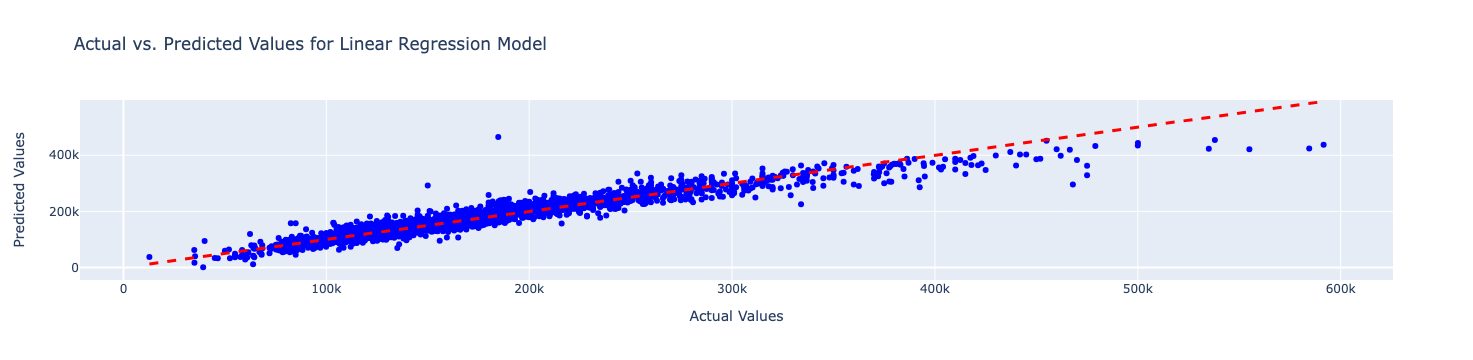

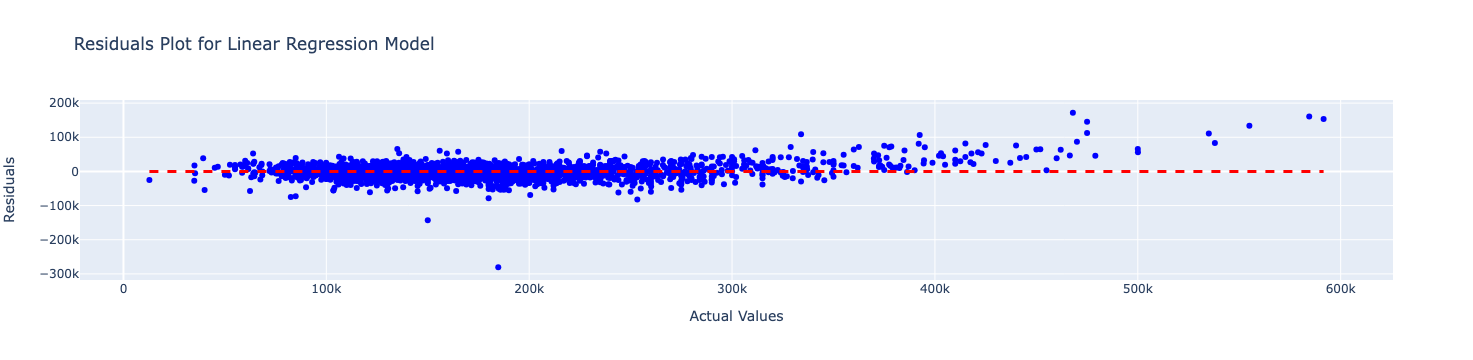

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     359.1
Date:                Mon, 22 Jan 2024   Prob (F-statistic):               0.00
Time:                        22:28:29   Log-Likelihood:                -29286.
No. Observations:                2571   AIC:                         5.872e+04
Df Residuals:                    2498   BIC:                         5.915e+04
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -7.264e+

In [193]:
#the features will be X (independent variables)
X = ft_train.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = ft_train['SalePrice']
y_array = y.values


# Perform linear regression using scikit-learn
model = LinearRegression()
model.fit(X, y)

X_with_intercept = sm.add_constant(X)  # Add intercept term
model_sm = sm.OLS(y,X_with_intercept).fit()

# Make predictions using the trained model
predictions = model.predict(X)


# Rsquared value
print("R Squared on the test set:", r2_score(y, predictions))


# Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y, predictions)
print("Mean Squared Error (MSE) on the test set:", mse)

# Root Mean Squared Error (RMSE) on the test set
rmse = mean_squared_error(y, predictions, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", rmse)



# Create a scatter plot with Plotly
fig = go.Figure()

# Add a scatter plot for actual vs. predicted values
fig.add_trace(go.Scatter(x=y, y=predictions, mode='markers', marker=dict(color='blue'), 
                         name='Actual vs. Predicted'))
# Add a diagonal line for perfect predictions
fig.add_shape(type="line", x0=min(y), x1=max(y), y0=min(y), y1=max(y),
              line=dict(color="red", width=3, dash='dash'),
              name="Perfect Predictions")

# Update layout and axis labels
fig.update_layout(title="Actual vs. Predicted Values for Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Predicted Values")

# Show the plot
fig.show()


# Plotting residuals
residuals = y - predictions
fig2 = go.Figure()

# Add a scatter plot for actual values and residuals
fig2.add_trace(go.Scatter(x=y, y=residuals, mode='markers', marker=dict(color='blue'), 
                         name='Residuals'))

# Add a horizontal line at y=0 for reference
fig2.add_shape(type="line", x0=min(y), x1=max(y), y0=0, y1=0,
              line=dict(color="red", width=3, dash='dash'),
              name="Zero Residuals Line")


fig2.update_layout(title="Residuals Plot for Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Residuals")

fig2.show()


# Using statsmodels to check p-values
print(model_sm.summary())
print('\n')

# Mean Squared Error (MSE)
mse = mean_squared_error(y, predictions)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y, predictions, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

print('\n')

print("F-statistic:", model_sm.fvalue)
print("F-statistic p-value:", model_sm.f_pvalue)

# Test Train Split Model

I was originally using the full dataset to train my model and test it on the same data. We will now look at how the results are from splitting the data.

R Squared on the test set: 0.9108364566777827
Mean Squared Error (MSE) on the test set: 434722879.32093465
Root Mean Squared Error (RMSE) on the test set: 20850.009096423306


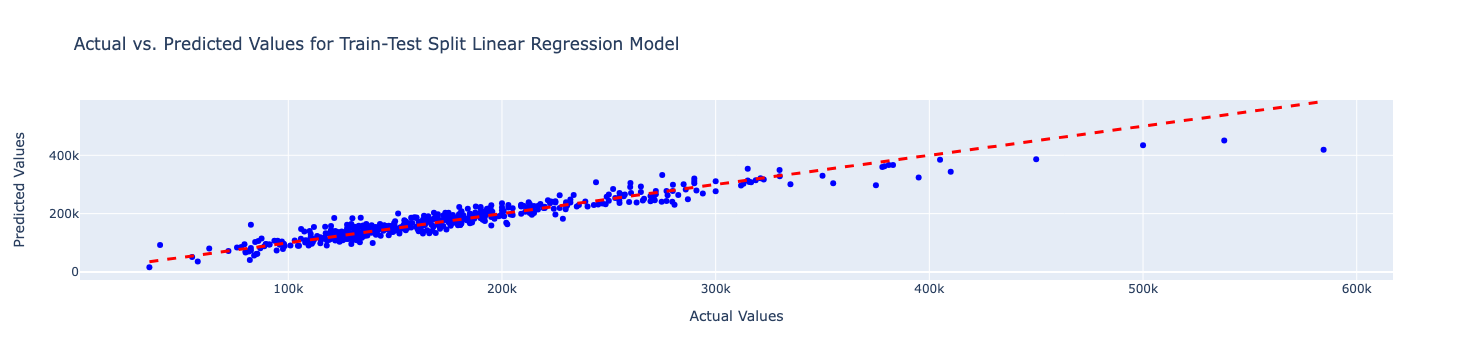

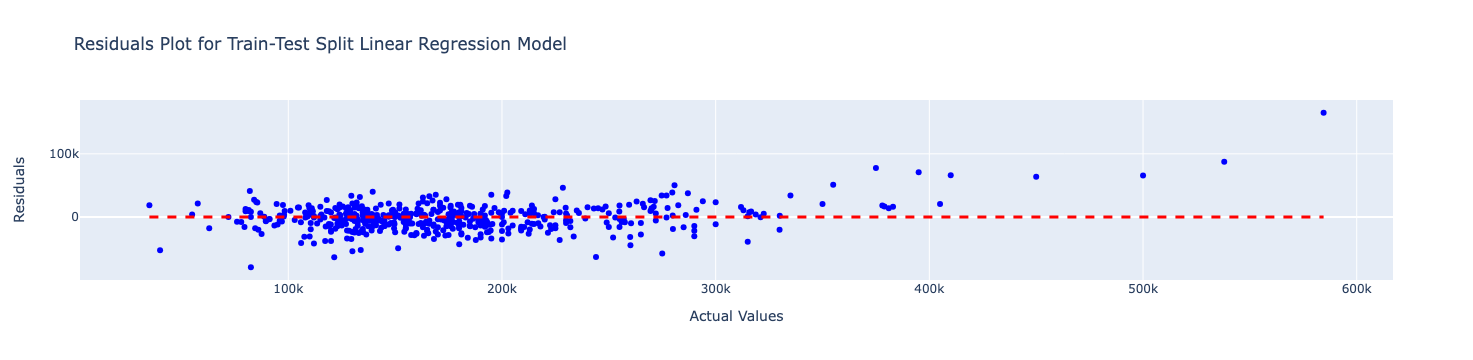

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Rsquared value
print("R Squared on the test set:", r2_score(y_test, predictions))


# Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE) on the test set:", mse)

# Root Mean Squared Error (RMSE) on the test set
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", rmse)


# Create a scatter plot with Plotly
fig = go.Figure()

# Add a scatter plot for actual vs. predicted values on the test set
fig.add_trace(go.Scatter(x=y_test, y=predictions, mode='markers', marker=dict(color='blue'), 
                         name='Actual vs. Predicted'))
# Add a diagonal line for perfect predictions
fig.add_shape(type="line", x0=min(y_test), x1=max(y_test), y0=min(y_test), y1=max(y_test),
              line=dict(color="red", width=3, dash='dash'),
              name="Perfect Predictions")

# Update layout and axis labels
fig.update_layout(title="Actual vs. Predicted Values for Train-Test Split Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Predicted Values")

# Show the plot
fig.show()

# Plotting residuals
residuals = y_test - predictions
fig2 = go.Figure()

# Add a scatter plot for actual values and residuals on the test set
fig2.add_trace(go.Scatter(x=y_test, y=residuals, mode='markers', marker=dict(color='blue'), 
                         name='Residuals'))

# Add a horizontal line at y=0 for reference
fig2.add_shape(type="line", x0=min(y_test), x1=max(y_test), y0=0, y1=0,
              line=dict(color="red", width=3, dash='dash'),
              name="Zero Residuals Line")

fig2.update_layout(title="Residuals Plot for Train-Test Split Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Residuals")

fig2.show()

print('\n')


# K-Fold Multiple Linear Regression

In [195]:

#the features will be X (independent variables)
X = ft_train.drop('SalePrice', axis=1)
#the target (dependent variable) will be y
y = ft_train['SalePrice']

# Create a linear regression model
model = LinearRegression()

# Specify the number of folds for K-Fold Cross-Validation
num_folds = 5 # You can adjust this number based on your preference

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

# Display the cross-validation scores
print("Cross-Validation Scores:", cv_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}")


Cross-Validation Scores: [0.91083646 0.83352205 0.91371303 0.89013025 0.90717417] 

Mean R^2: 0.8910751913400043 

Standard Deviation R^2: 0.029917931001103508


In [196]:
# Create a Lasso regression model


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alpha = .1 # Regularization strength (adjust as needed)
lasso_model = Lasso(alpha=alpha)

# Fit the Lasso model on the training set
lasso_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
lasso_y_pred = lasso_model.predict(X_test_scaled)

# Evaluate the model
lasso_mse = mean_squared_error(y_test, lasso_y_pred)
lasso_r2 = r2_score(y_test, lasso_y_pred)
print(f'R-squared on the test set: {lasso_r2}')
print(f'Mean Squared Error on the test set: {lasso_mse}')
# Root Mean Squared Error (RMSE) on the test set
lasso_rmse = mean_squared_error(y_test, lasso_y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", lasso_rmse)

# Display the coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_model.coef_})
print('\nCoefficients:')
print(coefficients)

R-squared on the test set: 0.9108371333269315
Mean Squared Error on the test set: 434719580.27229506
Root Mean Squared Error (RMSE) on the test set: 20849.929982431477

Coefficients:
                 Feature   Coefficient
0              GrLivArea  21397.642221
1   Neighborhood_Blueste    421.936163
2    Neighborhood_BrDale    746.685959
3   Neighborhood_BrkSide  -2910.960945
4   Neighborhood_ClearCr  -1136.351149
..                   ...           ...
67       Condition1_RRAe   -997.389276
68       Condition1_RRAn   1267.940695
69       Condition1_RRNe    157.128705
70       Condition1_RRNn   -362.739183
71          BedroomAbvGr  -3500.245191

[72 rows x 2 columns]


In [197]:
# Create a Ridge regression model


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alpha = 0.1  # Regularization strength (adjust as needed)
ridge_model = Ridge(alpha=alpha)

# Fit the Lasso model on the training set
ridge_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
ridge_y_pred = ridge_model.predict(X_test_scaled)

# Evaluate the model
ridge_mse = mean_squared_error(y_test, ridge_y_pred)
ridge_r2 = r2_score(y_test, ridge_y_pred)
print(f'R-squared on the test set: {ridge_r2}')
print(f'Mean Squared Error on the test set: {ridge_mse}')
# Root Mean Squared Error (RMSE) on the test set
ridge_rmse = mean_squared_error(y_test, ridge_y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", ridge_rmse)

# Display the coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': ridge_model.coef_})
print('\nCoefficients:')
print(coefficients)

R-squared on the test set: 0.9108358529725147
Mean Squared Error on the test set: 434725822.72675467
Root Mean Squared Error (RMSE) on the test set: 20850.079681544496

Coefficients:
                 Feature   Coefficient
0              GrLivArea  21393.442263
1   Neighborhood_Blueste    425.449275
2    Neighborhood_BrDale    752.731818
3   Neighborhood_BrkSide  -2896.776555
4   Neighborhood_ClearCr  -1127.334980
..                   ...           ...
67       Condition1_RRAe   -997.385268
68       Condition1_RRAn   1268.207106
69       Condition1_RRNe    157.282453
70       Condition1_RRNn   -362.719275
71          BedroomAbvGr  -3499.702334

[72 rows x 2 columns]


In [198]:
# Create a Elastic-Net regression model


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alpha = 0.1  # Regularization strength (adjust as needed)
l1_ratio = 0.9

elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

# Fit the Lasso model on the training set
elastic_net_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
elastic_y_pred = elastic_net_model.predict(X_test_scaled)

# Evaluate the model
elastic_mse = mean_squared_error(y_test, elastic_y_pred)
elastic_r2 = r2_score(y_test, elastic_y_pred)
print(f'R-squared on the test set: {elastic_r2}')
print(f'Mean Squared Error on the test set: {elastic_mse}')
# Root Mean Squared Error (RMSE) on the test set
elastic_rmse = mean_squared_error(y_test, elastic_y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", elastic_rmse)

# Display the coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': elastic_net_model.coef_})
print('\nCoefficients:')
print(coefficients)

R-squared on the test set: 0.9105576441161175
Mean Squared Error on the test set: 436082248.8017986
Root Mean Squared Error (RMSE) on the test set: 20882.58242655344

Coefficients:
                 Feature   Coefficient
0              GrLivArea  20535.322902
1   Neighborhood_Blueste    839.426181
2    Neighborhood_BrDale   1422.293937
3   Neighborhood_BrkSide  -1014.917465
4   Neighborhood_ClearCr    119.074704
..                   ...           ...
67       Condition1_RRAe  -1037.887847
68       Condition1_RRAn   1225.749842
69       Condition1_RRNe    143.260057
70       Condition1_RRNn   -358.090103
71          BedroomAbvGr  -3309.736601

[72 rows x 2 columns]
